In [ ]:
from torchvision.datasets import CIFAR10;
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip;
from torch.utils.data import DataLoader;

from torch import cuda;
import torch;
import torch.nn as nn;
import torch.optim as optim
import torch.nn.functional as func

import matplotlib.pyplot as plt;

import time;

In [ ]:
directory = "./CIFAR10"
device = "cuda" if cuda.is_available else "cpu";
print(device);

# PARAMETERS OF MODEL
batch_size = 128;
num_classes = 10;
num_epochs = 20;
learning_rate = 0.001;

cuda


In [ ]:
def get_train_data(directory, batch_size):

    transform = Compose([ RandomCrop(32, padding=4), RandomHorizontalFlip(), ToTensor(),
                        Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

    trainset = CIFAR10(root=directory, train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    return trainloader;

def get_test_data(directory, batch_size):

    transform = Compose([ToTensor(), Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

    trainset = CIFAR10(root=directory, train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    return trainloader;

In [ ]:
train_data = get_train_data(directory, batch_size);
test_data = get_test_data(directory, batch_size);
print(f"shape train data: {train_data.dataset.data.shape}");
print(f"shape train data: {test_data.dataset.data.shape}")

100%|██████████| 170M/170M [00:02<00:00, 70.3MB/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified
shape train data: (50000, 32, 32, 3)
shape train data: (50000, 32, 32, 3)


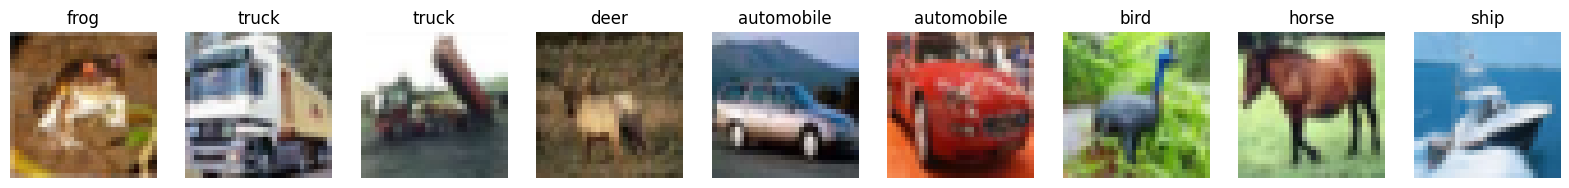

In [ ]:
fig, ax = plt.subplots(1, 9, figsize = (20, 8))
for index in range(0, 9):
    ax[index].imshow(train_data.dataset.data[index])
    ax[index].axis("off")
    ax[index].set_title((train_data.dataset.classes[train_data.dataset.targets[index]]))

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = func.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = func.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):

        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):

        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):

        out = func.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = func.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [ ]:
model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=0.9, weight_decay=5e-4)

In [ ]:
graphic_loss = []
graphic_acc = []

for epoch in range(num_epochs):

    loss_list = []
    accuracy_list = []

    model.train()

    time_begin = time.time()

    for batch_idx, (inputs, targets) in enumerate(train_data):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_list.append(loss)
        accuracy_list.append(torch.mean(torch.argmax(outputs, dim = 1) == targets, dtype = float))

    time_end = time.time()
    deltaTime = time_end - time_begin

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Loss: {loss.item():.3f}, "
          f"Accuracy: {torch.stack(accuracy_list).mean():.4f}, "
          f"Time: {deltaTime:.2f} "
          )

    graphic_loss.append(torch.stack(loss_list).mean().cpu().detach().numpy())
    graphic_acc.append(torch.stack(accuracy_list).mean().cpu().detach().numpy())

Epoch 1/20, Loss: 1.464, Accuracy: 0.3994, Time: 71.02 
Epoch 2/20, Loss: 1.012, Accuracy: 0.5788, Time: 72.47 
Epoch 3/20, Loss: 0.900, Accuracy: 0.6627, Time: 72.82 
Epoch 4/20, Loss: 0.872, Accuracy: 0.7163, Time: 72.57 
Epoch 5/20, Loss: 0.451, Accuracy: 0.7594, Time: 72.68 
Epoch 6/20, Loss: 0.500, Accuracy: 0.7874, Time: 72.60 
Epoch 7/20, Loss: 0.406, Accuracy: 0.8091, Time: 72.50 
Epoch 8/20, Loss: 0.619, Accuracy: 0.8274, Time: 72.27 
Epoch 9/20, Loss: 0.407, Accuracy: 0.8418, Time: 72.58 
Epoch 10/20, Loss: 0.465, Accuracy: 0.8533, Time: 72.70 
Epoch 11/20, Loss: 0.338, Accuracy: 0.8634, Time: 72.26 
Epoch 12/20, Loss: 0.413, Accuracy: 0.8763, Time: 72.56 
Epoch 13/20, Loss: 0.290, Accuracy: 0.8810, Time: 72.74 
Epoch 14/20, Loss: 0.264, Accuracy: 0.8906, Time: 72.59 
Epoch 15/20, Loss: 0.299, Accuracy: 0.8957, Time: 72.70 
Epoch 16/20, Loss: 0.464, Accuracy: 0.9055, Time: 72.64 
Epoch 17/20, Loss: 0.247, Accuracy: 0.9083, Time: 72.40 
Epoch 18/20, Loss: 0.387, Accuracy: 0.91

In [ ]:
torch.save(model.state_dict(), "model")


In [ ]:
import numpy as np

In [ ]:
np.save("loss", np.array(graphic_loss))
np.save("acc", np.array(graphic_acc))


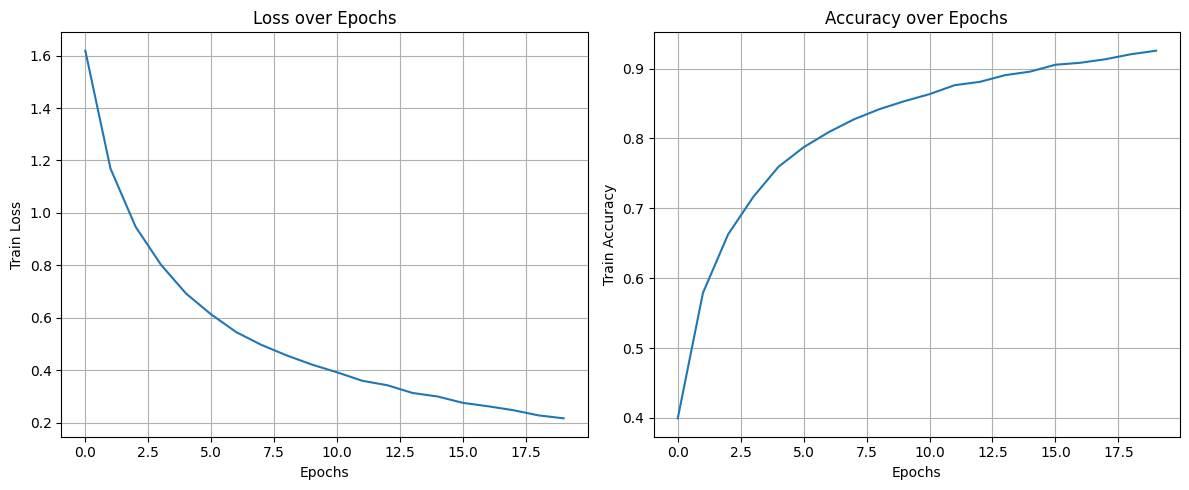

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(graphic_loss)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Train Loss")
ax1.set_title("Loss over Epochs")
ax1.grid(True)

ax2.plot(graphic_acc)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Train Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def test():
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, targets in test_data:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            test_acc += (predicted == targets).sum()
    print(f'Test Loss: {loss / total:.5f}')
    print(f'Test Accuracy: {test_acc / total:.5f}')

test()

Test Loss: 0.00000
Test Accuracy: 0.93740
